In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import Models.Get_data as Gd
import numpy as np
import random
from Models.CAE_LSTM import CAE_LSTM_seq2seq
from torchinfo import summary
import pickle
import os
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import os

In [2]:
latent_space = 25
window_size = 10
step_size = 3
batch_size = 5

# 获取目录路径
dirpath = os.path.dirname(f'/home/wl4023/github_repos/IRP/predict result/Latent space {latent_space}/')
# 创建目录（如果不存在）
os.makedirs(dirpath, exist_ok=True)

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(66)  # 你可以选择任意一个数字作为种子
# 启用浮点数异常检测
# torch.autograd.set_detect_anomaly(True)
directory = '/home/wl4023/data/Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]

In [4]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available
Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda:0


In [5]:
with open('/home/wl4023/github_repos/IRP/preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)
print(preprocessor.mean, preprocessor.std)

6.95707893371582 9.811119079589844


In [6]:
dataset, length = Gd.get_all_nodes(folders[:-1])
dataset = np.expand_dims(dataset[:, :, 0], axis=1)

dataset = torch.tensor(dataset, dtype=torch.float32)
dataset = Gd.segment_data_torch(dataset, length, window_size, step_size)

data = Gd.MyDataset(dataset[:, 0:5, :, :], dataset[:, -5:, :, :])
train_set, val_set = random_split(data, [0.8, 0.2])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)

In [7]:
dataset_1, length = Gd.get_all_nodes(folders[-1:])
dataset_1 = np.expand_dims(dataset_1[:, :, 0], axis=1)

dataset_1 = torch.tensor(dataset_1, dtype=torch.float32)
dataset_1 = Gd.segment_data_torch(dataset_1, length, window_size, step_size)

test_data = Gd.MyDataset(dataset_1[:, 0:5, :, :], dataset_1[:, -5:, :, :])

test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

## train

In [8]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_true, y_pred):
        return torch.sqrt(self.mse(y_true, y_pred))
    
class NRMSE(nn.Module):
    def __init__(self, total_dataset):
        super(NRMSE, self).__init__()
        self.rmse = RMSELoss()
        self.factor = total_dataset.max()-total_dataset.min()

    def forward(self, y_true, y_pred):
        return self.rmse(y_true, y_pred)/self.factor

In [9]:
def train(model, train_loader, val_loader, test_loader, criterion, metric, metric_test, optimizer, scheduler=None, device=device, epochs=30, seq_len=5):
    train_NRMSELoss_list = []
    train_RMSELoss_list = []

    val_NRMSELoss_list = []
    val_RMSELoss_list = []

    test_RMSELoss_list = []
    test_NRMSELoss_list = []

    min_loss = 10000
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_metric = 0
        for x, y in tqdm(train_loader):
            input = preprocessor.transform(x).to(device)
            label = preprocessor.transform(y).to(device)
            if torch.isnan(input).any():
                print(111)
            optimizer.zero_grad()
            predict = model(input, seq_len)
            
            loss = criterion(label, predict)
            loss.backward()
            optimizer.step()

            recon_predict = preprocessor.inverse_transform(predict.cpu())
            # print(recon_predict.max(), train_loss, len(train_loader))
            train_loss += criterion(y, recon_predict).item()
            train_metric += metric(y, recon_predict).item()
            # print(train_loss, len(train_loader))
        
        train_loss /= len(train_loader)
        # print(train_loss, len(train_loader))
        train_metric /= len(train_loader)
        train_RMSELoss_list.append(train_loss)
        train_NRMSELoss_list.append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_metric = 0
            for x, y in val_loader:
                input = preprocessor.transform(x).to(device)
                # label = preprocessor.transform(y).to(device)
                predict = model(input, seq_len)

                recon_predict = preprocessor.inverse_transform(predict.cpu())
                val_loss += criterion(y, recon_predict).item()
                val_metric += metric(y, recon_predict).item()
    
            val_loss /= len(val_loader)
            val_metric /= len(val_loader)
            val_RMSELoss_list.append(val_loss)
            val_NRMSELoss_list.append(val_metric)
        
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_metric)  # 使用验证损失来调整学习率
            else:
                scheduler.step()

        model.eval()
        with torch.no_grad():
            test_loss = 0
            test_metric = 0
            for x, y in test_loader:
                input = preprocessor.transform(x).to(device)
                # label = preprocessor.transform(y).to(device)
                predict = model(input, seq_len)

                recon_predict = preprocessor.inverse_transform(predict.cpu())

                # recon_predict_list.append(recon_predict)
                test_loss += criterion(y, recon_predict).item()
                test_metric += metric_test(y, recon_predict).item()
            
            test_loss /= len(test_loader)
            test_metric /= len(test_loader)
            test_RMSELoss_list.append(test_loss)
            test_NRMSELoss_list.append(test_metric)

        print(f'Epoch {epoch + 1}/{epochs}, train Loss: {train_loss}, NRMSE_train_loss: {train_metric}, val Loss: {val_loss}, NRMSE_val_loss: {val_metric}, Ave test loss: {test_loss}, Ave test metric: {test_metric}')
        
        if min_loss >= test_loss:
            min_loss = test_loss
            torch.save(model.state_dict(), f'/home/wl4023/github_repos/IRP/predict result/Latent space {latent_space}/CAE_LSTM.pth')

    return train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list, test_RMSELoss_list, test_NRMSELoss_list

In [10]:
# Define the weights initialization function
def initialize_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

In [11]:
model = CAE_LSTM_seq2seq(latent_space, 100)
model.apply(initialize_weights)
summary(model, input_data=(train_set[0:5][0], 5))

Layer (type:depth-idx)                   Output Shape              Param #
CAE_LSTM_seq2seq                         [5, 5, 1, 97149]          --
├─CAE_LSTM_encoder: 1-1                  [5, 100]                  --
│    └─Encoder: 2-1                      [5, 25]                   --
│    │    └─Conv1d: 3-1                  [5, 4, 97149]             36
│    │    └─Dropout: 3-2                 [5, 4, 97149]             --
│    │    └─MaxPool1d: 3-3               [5, 4, 19429]             --
│    │    └─Conv1d: 3-4                  [5, 4, 19429]             132
│    │    └─Dropout: 3-5                 [5, 4, 19429]             --
│    │    └─MaxPool1d: 3-6               [5, 4, 3885]              --
│    │    └─Conv1d: 3-7                  [5, 1, 3885]              33
│    │    └─LeakyReLU: 3-8               [5, 1, 3885]              --
│    │    └─Dropout: 3-9                 [5, 1, 3885]              --
│    │    └─MaxPool1d: 3-10              [5, 1, 777]               --
│    │    └─Ad

In [12]:
model = model.to(device)
optimizer = optim.Adam(model.parameters())
criterion = RMSELoss()
metric = NRMSE(dataset)
metric_test = NRMSE(dataset_1)
train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list, test_RMSELoss_list, test_NRMSELoss_list = train(model,
                                                                                                                                train_loader,
                                                                                                                                val_loader,
                                                                                                                                test_loader,
                                                                                                                                criterion,
                                                                                                                                metric,
                                                                                                                                metric_test,
                                                                                                                                optimizer,
                                                                                                                                device=device,
                                                                                                                                epochs=50,
                                                                                                                                seq_len=5)

100%|██████████| 144/144 [00:18<00:00,  7.74it/s]


Epoch 1/50, train Loss: 7.946440151996082, NRMSE_train_loss: 0.15272090433993274, val Loss: 7.7803316778606835, NRMSE_val_loss: 0.1495285009344419, Ave test loss: 5.623096235336796, Ave test metric: 0.3197709475794146


100%|██████████| 144/144 [00:17<00:00,  8.39it/s]


Epoch 2/50, train Loss: 5.810696711142858, NRMSE_train_loss: 0.11167451602199839, val Loss: 6.7665336926778155, NRMSE_val_loss: 0.13004453997645113, Ave test loss: 4.734992134955622, Ave test metric: 0.2692667673672399


100%|██████████| 144/144 [00:17<00:00,  8.43it/s]


Epoch 3/50, train Loss: 5.0237627807590695, NRMSE_train_loss: 0.09655060370763142, val Loss: 5.903972168763478, NRMSE_val_loss: 0.11346715595573187, Ave test loss: 3.7963722751986597, Ave test metric: 0.21588988025342265


100%|██████████| 144/144 [00:17<00:00,  8.45it/s]


Epoch 4/50, train Loss: 4.712477361990346, NRMSE_train_loss: 0.09056807723310259, val Loss: 5.415704091389974, NRMSE_val_loss: 0.10408323827303118, Ave test loss: 3.642428844205795, Ave test metric: 0.20713551294419072


100%|██████████| 144/144 [00:17<00:00,  8.42it/s]


Epoch 5/50, train Loss: 4.310424008303219, NRMSE_train_loss: 0.08284110102492075, val Loss: 5.376171701484257, NRMSE_val_loss: 0.10332347390552361, Ave test loss: 3.4467387583947953, Ave test metric: 0.19600712387792527


100%|██████████| 144/144 [00:17<00:00,  8.40it/s]


Epoch 6/50, train Loss: 3.9902010692490473, NRMSE_train_loss: 0.07668680599373248, val Loss: 4.878152781062656, NRMSE_val_loss: 0.09375215704656309, Ave test loss: 2.7030167733469317, Ave test metric: 0.15371357721667137


100%|██████████| 144/144 [00:17<00:00,  8.39it/s]


Epoch 7/50, train Loss: 3.779686370243629, NRMSE_train_loss: 0.07264096996126075, val Loss: 5.09253450234731, NRMSE_val_loss: 0.0978723122841782, Ave test loss: 3.261390147670623, Ave test metric: 0.18546682884616236


100%|██████████| 144/144 [00:17<00:00,  8.46it/s]


Epoch 8/50, train Loss: 3.6192680125435195, NRMSE_train_loss: 0.06955792469024244, val Loss: 4.823594020472632, NRMSE_val_loss: 0.09270360393242703, Ave test loss: 3.6106962465470835, Ave test metric: 0.20533096309631102


100%|██████████| 144/144 [00:17<00:00,  8.47it/s]


Epoch 9/50, train Loss: 3.4412107318639755, NRMSE_train_loss: 0.06613588014928003, val Loss: 4.217609465122223, NRMSE_val_loss: 0.08105731858975357, Ave test loss: 3.213639259338379, Ave test metric: 0.18275135899743727


100%|██████████| 144/144 [00:17<00:00,  8.41it/s]


Epoch 10/50, train Loss: 3.303203447825379, NRMSE_train_loss: 0.06348354844117744, val Loss: 4.100546750757429, NRMSE_val_loss: 0.0788075164374378, Ave test loss: 3.5758359970584994, Ave test metric: 0.20334855010432581


100%|██████████| 144/144 [00:17<00:00,  8.46it/s]


Epoch 11/50, train Loss: 3.096297223534849, NRMSE_train_loss: 0.05950706290443324, val Loss: 4.16314478052987, NRMSE_val_loss: 0.08001057379361656, Ave test loss: 3.9480555057525635, Ave test metric: 0.22451571351097477


100%|██████████| 144/144 [00:17<00:00,  8.44it/s]


Epoch 12/50, train Loss: 3.0423544173439345, NRMSE_train_loss: 0.058470347521102264, val Loss: 3.696349389023251, NRMSE_val_loss: 0.0710393347673946, Ave test loss: 3.0958592045691704, Ave test metric: 0.17605351055822066


100%|██████████| 144/144 [00:17<00:00,  8.46it/s]


Epoch 13/50, train Loss: 2.825430797619952, NRMSE_train_loss: 0.054301339822510876, val Loss: 4.0877687732378645, NRMSE_val_loss: 0.07856193836778402, Ave test loss: 3.5139690829861547, Ave test metric: 0.1998303407622922


100%|██████████| 144/144 [00:17<00:00,  8.46it/s]


Epoch 14/50, train Loss: 2.751592040475872, NRMSE_train_loss: 0.05288224866510265, val Loss: 3.511060873667399, NRMSE_val_loss: 0.0674783145594928, Ave test loss: 3.6527778487051688, Ave test metric: 0.2077240357475896


100%|██████████| 144/144 [00:17<00:00,  8.45it/s]


Epoch 15/50, train Loss: 2.566332100994057, NRMSE_train_loss: 0.0493217781962206, val Loss: 3.1778894695970745, NRMSE_val_loss: 0.06107516669564777, Ave test loss: 3.558426034065985, Ave test metric: 0.20235849147842777


100%|██████████| 144/144 [00:16<00:00,  8.48it/s]


Epoch 16/50, train Loss: 2.639454777869913, NRMSE_train_loss: 0.05072710717407366, val Loss: 3.3432282937897577, NRMSE_val_loss: 0.06425277723206414, Ave test loss: 3.679539703553723, Ave test metric: 0.20924591297103512


100%|██████████| 144/144 [00:17<00:00,  8.43it/s]


Epoch 17/50, train Loss: 2.4579074846373663, NRMSE_train_loss: 0.04723798932455894, val Loss: 3.479535977045695, NRMSE_val_loss: 0.06687244441774157, Ave test loss: 3.8137156501893075, Ave test metric: 0.21687615158096438


100%|██████████| 144/144 [00:17<00:00,  8.42it/s]


Epoch 18/50, train Loss: 2.349353313446045, NRMSE_train_loss: 0.045151710173942976, val Loss: 2.772165063354704, NRMSE_val_loss: 0.05327763698167271, Ave test loss: 2.8082152566602154, Ave test metric: 0.15969594351706967


100%|██████████| 144/144 [00:17<00:00,  8.45it/s]


Epoch 19/50, train Loss: 2.2807946445213423, NRMSE_train_loss: 0.04383409600187507, val Loss: 2.580933521191279, NRMSE_val_loss: 0.049602399890621506, Ave test loss: 2.8323772030491985, Ave test metric: 0.1610699709384672


100%|██████████| 144/144 [00:17<00:00,  8.43it/s]


Epoch 20/50, train Loss: 2.3226611870858402, NRMSE_train_loss: 0.04463872001765089, val Loss: 2.9389537705315485, NRMSE_val_loss: 0.05648311305170258, Ave test loss: 3.4865648669581257, Ave test metric: 0.19827193262115603


100%|██████████| 144/144 [00:16<00:00,  8.50it/s]


Epoch 21/50, train Loss: 2.101295028295782, NRMSE_train_loss: 0.040384331937982805, val Loss: 2.544386347134908, NRMSE_val_loss: 0.04890000752897726, Ave test loss: 3.1969321850807435, Ave test metric: 0.18180127153473516


100%|██████████| 144/144 [00:17<00:00,  8.45it/s]


Epoch 22/50, train Loss: 2.137436726027065, NRMSE_train_loss: 0.04107893127689345, val Loss: 2.6122088929017386, NRMSE_val_loss: 0.05020347413503461, Ave test loss: 3.346418542246665, Ave test metric: 0.19030217345683806


100%|██████████| 144/144 [00:17<00:00,  8.43it/s]


Epoch 23/50, train Loss: 1.9826759335895379, NRMSE_train_loss: 0.03810461752841042, val Loss: 2.469099670648575, NRMSE_val_loss: 0.04745308899631103, Ave test loss: 3.0581407239360194, Ave test metric: 0.17390855858402868


100%|██████████| 144/144 [00:17<00:00,  8.46it/s]


Epoch 24/50, train Loss: 1.9790962959329288, NRMSE_train_loss: 0.03803582118254983, val Loss: 2.4706480304400125, NRMSE_val_loss: 0.047482846201294, Ave test loss: 2.6193606161302134, Ave test metric: 0.14895626854511998


100%|██████████| 144/144 [00:17<00:00,  8.44it/s]


Epoch 25/50, train Loss: 1.8413996158374681, NRMSE_train_loss: 0.035389458488983415, val Loss: 2.45943193965488, NRMSE_val_loss: 0.047267287503927946, Ave test loss: 3.055280316260553, Ave test metric: 0.17374589510502353


100%|██████████| 144/144 [00:17<00:00,  8.43it/s]


Epoch 26/50, train Loss: 1.7780157931976848, NRMSE_train_loss: 0.03417129861837667, val Loss: 2.922689331902398, NRMSE_val_loss: 0.05617053035853638, Ave test loss: 3.4575355283675657, Ave test metric: 0.19662110892034346


100%|██████████| 144/144 [00:17<00:00,  8.46it/s]


Epoch 27/50, train Loss: 1.7945854734215472, NRMSE_train_loss: 0.03448974777064803, val Loss: 2.2579317490259805, NRMSE_val_loss: 0.04339469886488385, Ave test loss: 2.805797899923017, Ave test metric: 0.1595584752578889


100%|██████████| 144/144 [00:17<00:00,  8.46it/s]


Epoch 28/50, train Loss: 1.7818578167094126, NRMSE_train_loss: 0.034245137707330287, val Loss: 2.545924577448103, NRMSE_val_loss: 0.04892957044972314, Ave test loss: 3.1452027443916566, Ave test metric: 0.17885955158741243


100%|██████████| 144/144 [00:16<00:00,  8.49it/s]


Epoch 29/50, train Loss: 1.723326587014728, NRMSE_train_loss: 0.03312023868137556, val Loss: 2.412070141898261, NRMSE_val_loss: 0.04635705100372434, Ave test loss: 3.2302058819801576, Ave test metric: 0.18369345799569162


100%|██████████| 144/144 [00:17<00:00,  8.40it/s]


Epoch 30/50, train Loss: 1.6078114935921297, NRMSE_train_loss: 0.030900179395555623, val Loss: 2.697593685653475, NRMSE_val_loss: 0.05184446621893181, Ave test loss: 3.342095551952239, Ave test metric: 0.19005633650287504


100%|██████████| 144/144 [00:17<00:00,  8.45it/s]


Epoch 31/50, train Loss: 1.611624504543013, NRMSE_train_loss: 0.030973460706364777, val Loss: 2.4212182694011264, NRMSE_val_loss: 0.046532866907202534, Ave test loss: 2.965920094520815, Ave test metric: 0.1686642102656826


100%|██████████| 144/144 [00:17<00:00,  8.42it/s]


Epoch 32/50, train Loss: 1.5625542617506452, NRMSE_train_loss: 0.03003039038998799, val Loss: 2.9824648367034063, NRMSE_val_loss: 0.057319342676136226, Ave test loss: 3.7434330755664456, Ave test metric: 0.21287936260623316


100%|██████████| 144/144 [00:17<00:00,  8.47it/s]


Epoch 33/50, train Loss: 1.5082708071503375, NRMSE_train_loss: 0.02898712842337166, val Loss: 2.7925021913316517, NRMSE_val_loss: 0.053668492266701326, Ave test loss: 3.6869584437339538, Ave test metric: 0.20966779753085105


100%|██████████| 144/144 [00:17<00:00,  8.46it/s]


Epoch 34/50, train Loss: 1.5049812686112192, NRMSE_train_loss: 0.028923907504779182, val Loss: 2.0574297308921814, NRMSE_val_loss: 0.03954129417737325, Ave test loss: 2.969643146761002, Ave test metric: 0.16887593029006834


100%|██████████| 144/144 [00:17<00:00,  8.40it/s]


Epoch 35/50, train Loss: 1.4172162831657462, NRMSE_train_loss: 0.027237171371881332, val Loss: 2.2992158664597406, NRMSE_val_loss: 0.04418812935344047, Ave test loss: 2.9587670910742974, Ave test metric: 0.1682574378867303


100%|██████████| 144/144 [00:17<00:00,  8.46it/s]


Epoch 36/50, train Loss: 1.433749522185988, NRMSE_train_loss: 0.027554919975551054, val Loss: 2.138416541947259, NRMSE_val_loss: 0.041097762218366064, Ave test loss: 2.8386579482786116, Ave test metric: 0.16142714023590088


100%|██████████| 144/144 [00:17<00:00,  8.47it/s]


Epoch 37/50, train Loss: 1.5135147364603148, NRMSE_train_loss: 0.029087910338097975, val Loss: 2.479012813833025, NRMSE_val_loss: 0.04764360789623526, Ave test loss: 3.604435759205972, Ave test metric: 0.20497494599511545


100%|██████████| 144/144 [00:17<00:00,  8.45it/s]


Epoch 38/50, train Loss: 1.4097243203885026, NRMSE_train_loss: 0.027093184924322285, val Loss: 2.0749510758452945, NRMSE_val_loss: 0.03987803325677911, Ave test loss: 3.260389881749307, Ave test metric: 0.18540994534569402


100%|██████████| 144/144 [00:17<00:00,  8.44it/s]


Epoch 39/50, train Loss: 1.3194433657659426, NRMSE_train_loss: 0.02535809496960913, val Loss: 2.3308695786529117, NRMSE_val_loss: 0.044796475364516176, Ave test loss: 3.689652181440784, Ave test metric: 0.2098209843520195


100%|██████████| 144/144 [00:17<00:00,  8.45it/s]


Epoch 40/50, train Loss: 1.315285778294007, NRMSE_train_loss: 0.025278191243867494, val Loss: 2.1070246034198337, NRMSE_val_loss: 0.040494447418799005, Ave test loss: 3.2246893913515153, Ave test metric: 0.18337975153999944


100%|██████████| 144/144 [00:16<00:00,  8.49it/s]


Epoch 41/50, train Loss: 1.3838019714587264, NRMSE_train_loss: 0.02659498895647832, val Loss: 2.01817305220498, NRMSE_val_loss: 0.038786828931834966, Ave test loss: 2.8678375290286158, Ave test metric: 0.16308650855095155


100%|██████████| 144/144 [00:16<00:00,  8.47it/s]


Epoch 42/50, train Loss: 1.2742028248806794, NRMSE_train_loss: 0.0244886268564086, val Loss: 2.10844416419665, NRMSE_val_loss: 0.04052172968578008, Ave test loss: 3.3484669577690864, Ave test metric: 0.1904186616020818


100%|██████████| 144/144 [00:17<00:00,  8.43it/s]


Epoch 43/50, train Loss: 1.2556139913698037, NRMSE_train_loss: 0.024131372176472925, val Loss: 2.092067801290088, NRMSE_val_loss: 0.04020699543050594, Ave test loss: 3.141223676743046, Ave test metric: 0.17863327264785767


100%|██████████| 144/144 [00:17<00:00,  8.46it/s]


Epoch 44/50, train Loss: 1.3065014493962128, NRMSE_train_loss: 0.025109367141137935, val Loss: 2.0999832352002463, NRMSE_val_loss: 0.04035912102295293, Ave test loss: 3.383553712598739, Ave test metric: 0.19241395592689514


100%|██████████| 144/144 [00:17<00:00,  8.46it/s]


Epoch 45/50, train Loss: 1.2605079905026488, NRMSE_train_loss: 0.02422542880392737, val Loss: 2.709755582941903, NRMSE_val_loss: 0.05207820303945078, Ave test loss: 3.861070563716273, Ave test metric: 0.21956910337171248


100%|██████████| 144/144 [00:17<00:00,  8.44it/s]


Epoch 46/50, train Loss: 1.2073364795909987, NRMSE_train_loss: 0.023203537152666185, val Loss: 2.1493233342965445, NRMSE_val_loss: 0.04130737752550178, Ave test loss: 3.7299243480928483, Ave test metric: 0.21211115775569792


100%|██████████| 144/144 [00:17<00:00,  8.44it/s]


Epoch 47/50, train Loss: 1.2146863353749116, NRMSE_train_loss: 0.023344792412697442, val Loss: 2.0839836763011084, NRMSE_val_loss: 0.04005162857679857, Ave test loss: 3.287604331970215, Ave test metric: 0.1869575616813475


100%|██████████| 144/144 [00:17<00:00,  8.43it/s]


Epoch 48/50, train Loss: 1.1559118061429925, NRMSE_train_loss: 0.022215217429523666, val Loss: 2.324414332707723, NRMSE_val_loss: 0.04467241310824951, Ave test loss: 3.3380115109105266, Ave test metric: 0.18982408796587297


100%|██████████| 144/144 [00:16<00:00,  8.48it/s]


Epoch 49/50, train Loss: 1.1470138476126723, NRMSE_train_loss: 0.02204420963405735, val Loss: 2.112118101782269, NRMSE_val_loss: 0.04059233873461684, Ave test loss: 3.422851716318438, Ave test metric: 0.19464873065871577


100%|██████████| 144/144 [00:16<00:00,  8.47it/s]


Epoch 50/50, train Loss: 1.2247778591182497, NRMSE_train_loss: 0.023538739213513002, val Loss: 2.806312855747011, NRMSE_val_loss: 0.053933915889097586, Ave test loss: 3.4267624731986754, Ave test metric: 0.19487112520202513


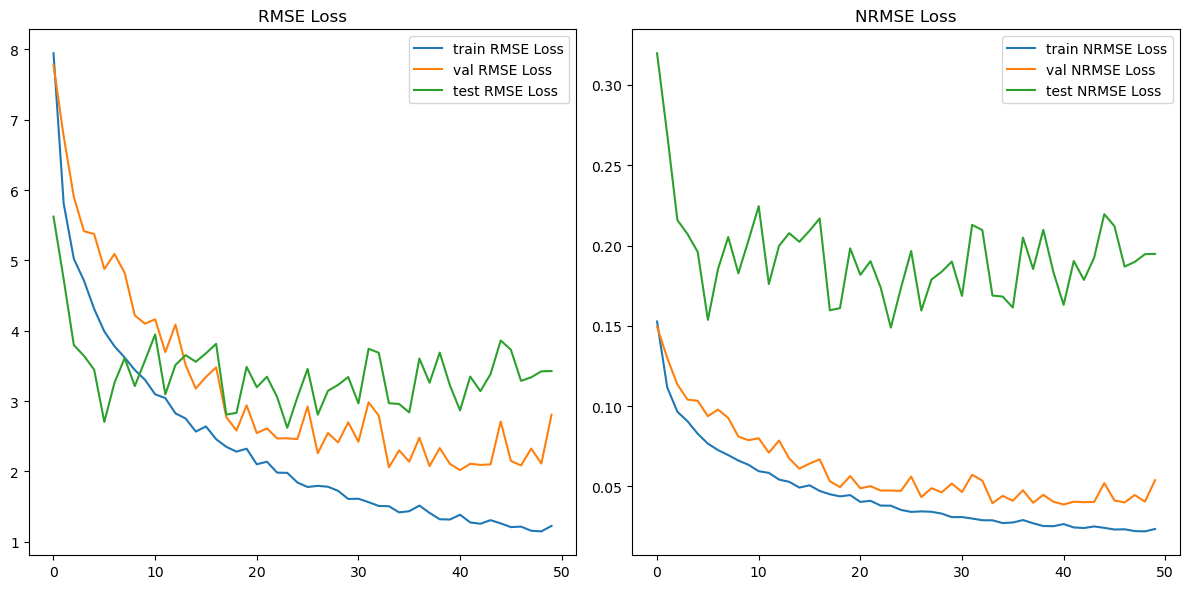

In [13]:
fig1, axs = plt.subplots(1, 2, figsize=(12, 6))
# train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list
axs[0].plot(train_RMSELoss_list, label='train RMSE Loss')
axs[0].plot(val_RMSELoss_list, label='val RMSE Loss')
axs[0].plot(test_RMSELoss_list, label='test RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].plot(train_NRMSELoss_list, label='train NRMSE Loss')
axs[1].plot(val_NRMSELoss_list, label='val NRMSE Loss')
axs[1].plot(test_NRMSELoss_list, label='test NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()

plt.tight_layout()  # 调整布局以防止重叠
# plt.savefig('CAE_train_loss.png')  # 你可以更改文件名或格式
plt.savefig(f'/home/wl4023/github_repos/IRP/predict result/Latent space {latent_space}/CAE_LSTM_train_loss.png')
plt.show()

In [14]:
test_RMSELoss_list = []
test_NRMSELoss_list = []

recon_predict_list = []

model.eval()
with torch.no_grad():
    test_loss = 0
    test_metric = 0
    for x, y in test_loader:
        input = preprocessor.transform(x).to(device)
        predict = model(input, 5)

        recon_predict = preprocessor.inverse_transform(predict)

        recon_predict_list.append(recon_predict.cpu())
        test_RMSELoss_list.append(criterion(y, recon_predict.cpu()).item())
        test_NRMSELoss_list.append(metric_test(y, recon_predict.cpu()).item())


recon_predict_list = torch.cat(recon_predict_list, dim=0).numpy()


test_rmse = np.array(test_RMSELoss_list)
test_nrmse = np.array(test_NRMSELoss_list)

test_loss = test_rmse.mean()
test_metric = test_nrmse.mean()
print(f'Ave test loss: {test_loss}, Ave test metric: {test_metric}')

Ave test loss: 3.4267624731986754, Ave test metric: 0.19487112520202513


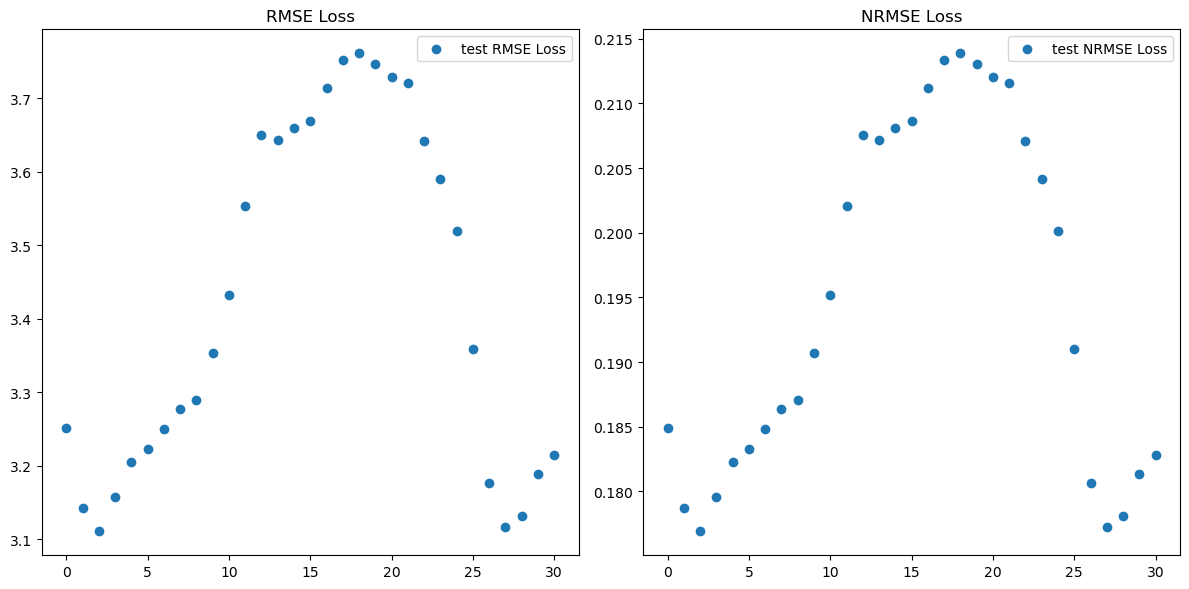

In [15]:
x = np.arange(0, len(test_loader))


# 保存数组到 .npy 文件
# np.save('test_rmse.npy', test_rmse)
# np.save('test_nrmse.npy', test_nrmse)

fig1, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(x, test_rmse, label='test RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].scatter(x, test_nrmse, label='test NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()


plt.tight_layout()  # 调整布局以防止重叠

# plt.savefig('CAE_test_loss.png')  # 你可以更改文件名或格式
plt.savefig(f'/home/wl4023/github_repos/IRP/predict result/Latent space {latent_space}/CAE_LSTM_test_loss.png')

plt.show()

In [16]:
def draw_pic(x, y, predict, coords):
    fig, axs = plt.subplots(3, 5, figsize=(30, 18))
    for i in range(axs.shape[-1]):
        axs[0][i].scatter(coords[:,0],coords[:,1],s = 5, c=x[i, :, :], cmap='bwr')
        axs[0][i].set_title(f'Origin Input {i+1}')

    for i in range(axs.shape[-1]):
        axs[1][i].scatter(coords[:,0],coords[:,1],s = 5, c=y[i, :, :], cmap='bwr')
        axs[1][i].set_title(f'Real Output {i+1}')

    for i in range(axs.shape[-1]):
        axs[2][i].scatter(coords[:,0],coords[:,1],s = 5, c=predict[i, :, :], cmap='bwr')
        axs[2][i].set_title(f'Real Output {i+1}')

    plt.savefig(f'/home/wl4023/github_repos/IRP/predict result/Latent space {latent_space}/CAE_LSTM_output.png')
    plt.show()
    plt.close()

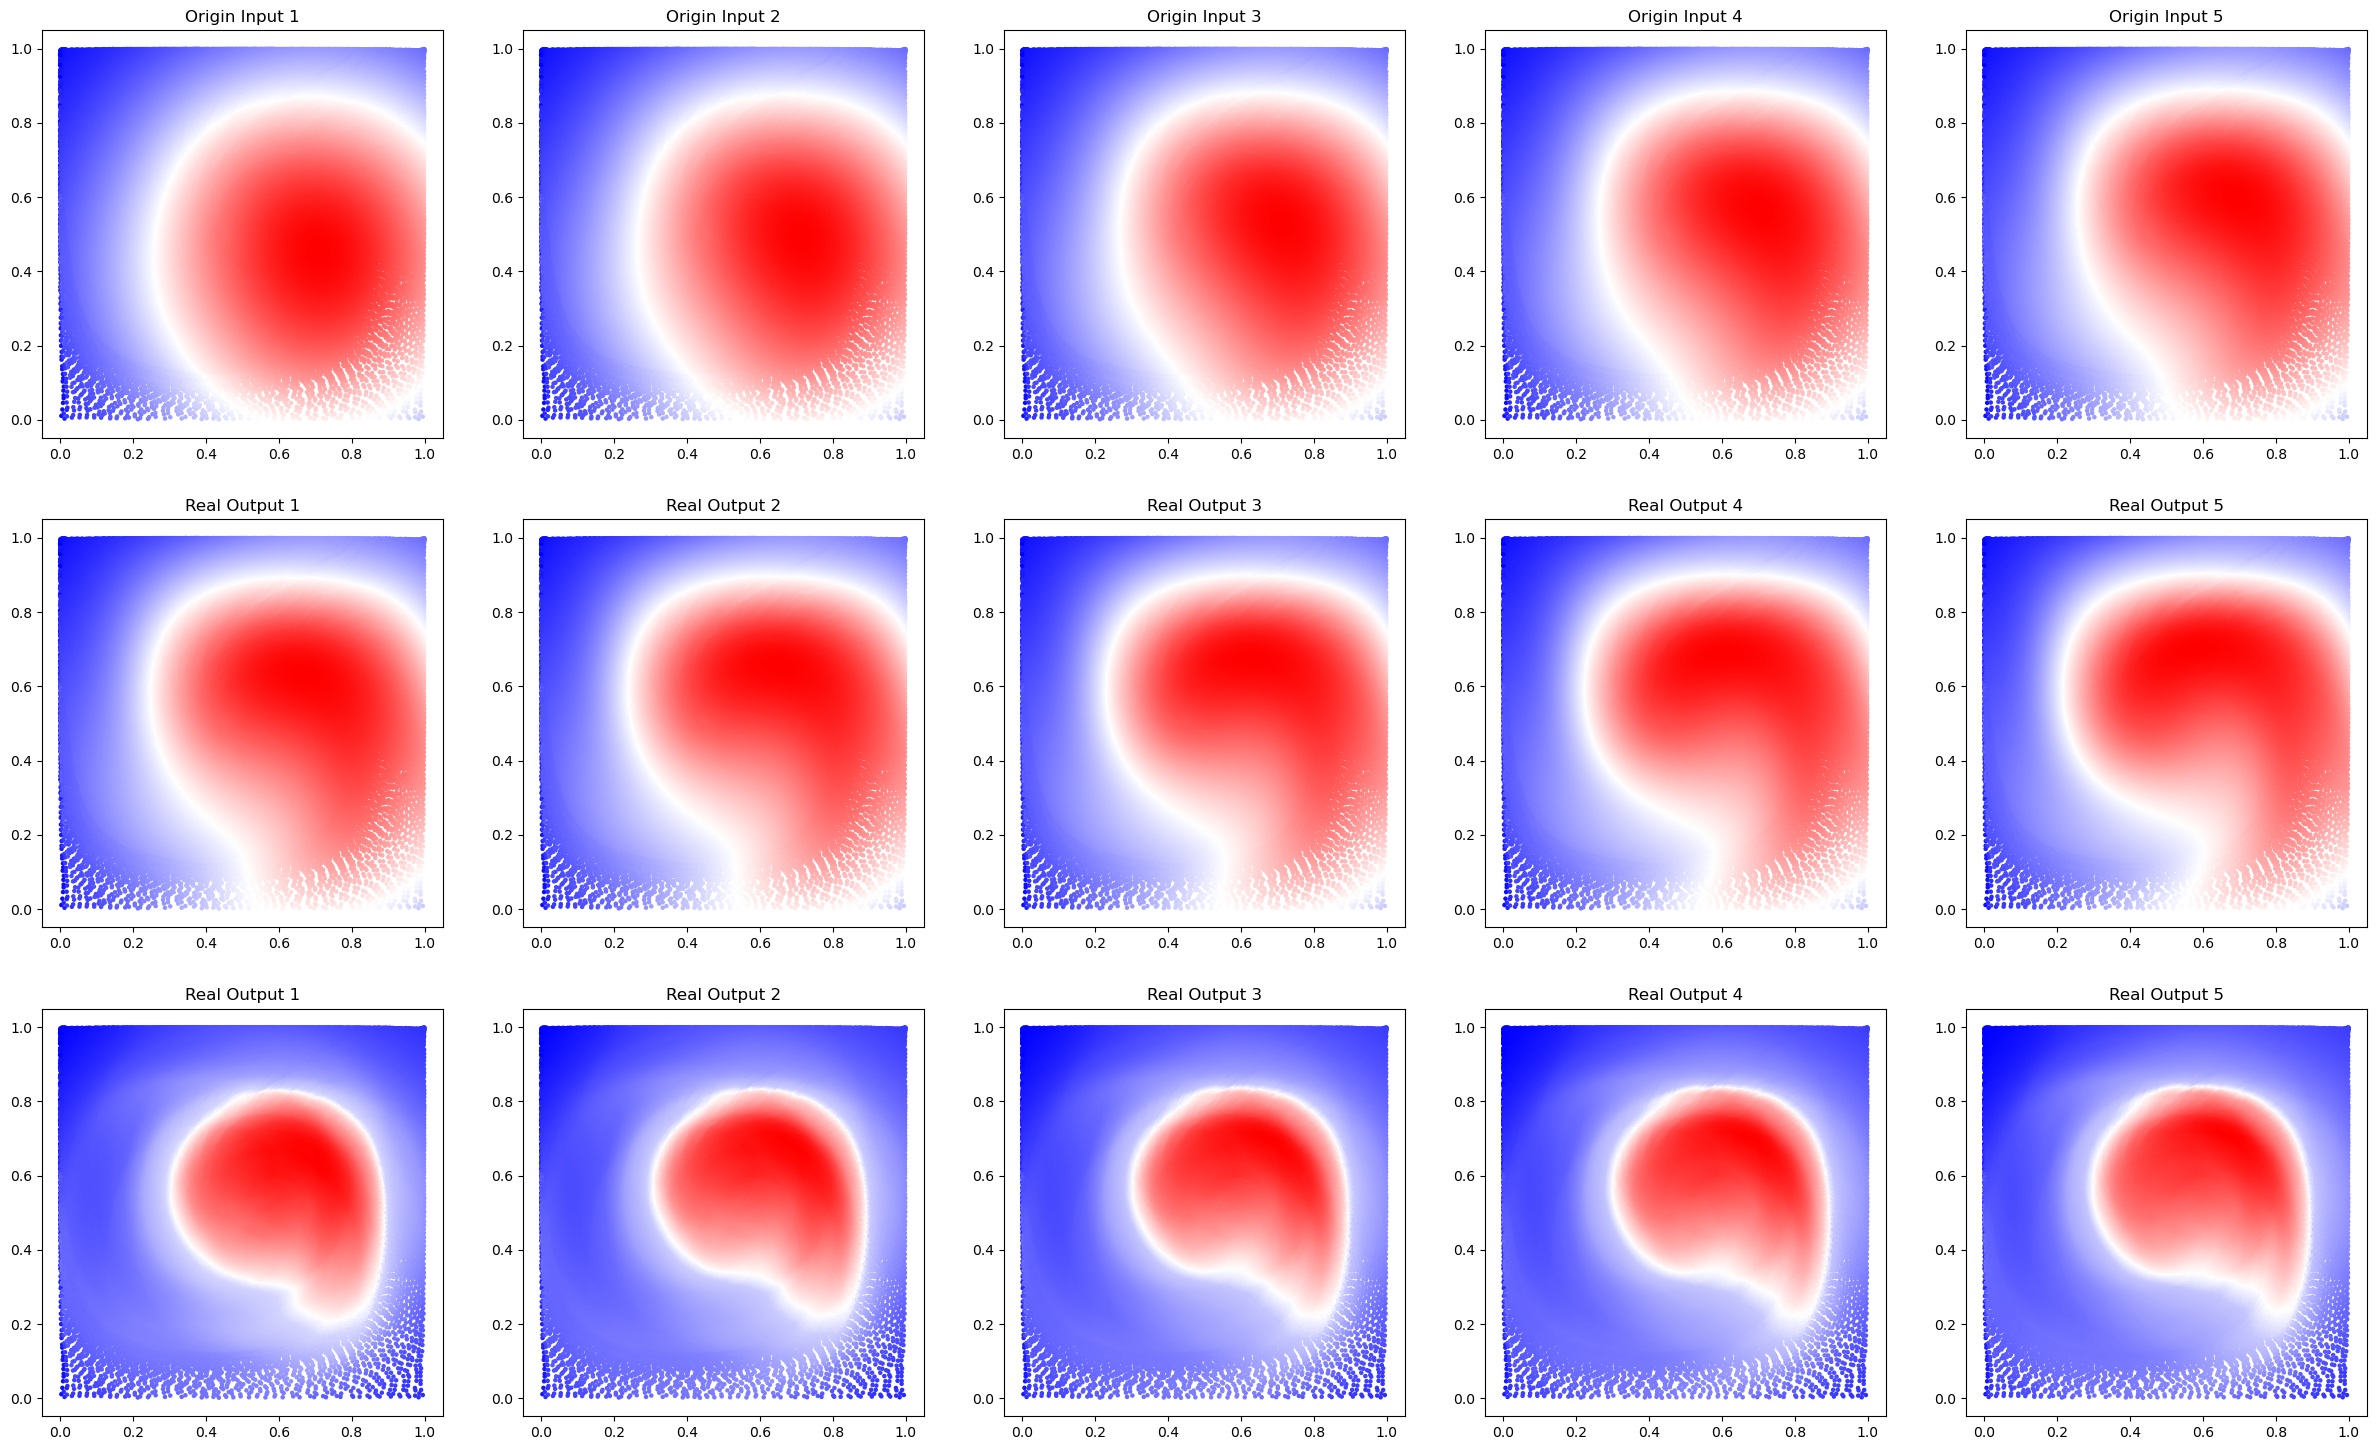

In [17]:
xyfile = "/home/wl4023/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
coords = np.load(xyfile)

x, y = test_data[0]
predict = recon_predict_list[0]
draw_pic(x, y, predict, coords)